# Distributed Deformable Registration with ITKElastix

This notebook demonstrates a basic pipeline for deformable image-to-image registration with `itk_dreg` and `itk-elastix`.

We build on the procedure developed in [`ElastixRegisterAndReduce.ipynb`](ElastixRegisterAndReduce.ipynb) and introduce multistage deformable registration with ITKElastix. We encourage new users and developers to first visit that notebook before proceeding here.

In [1]:
import os
import logging
import functools
import tempfile
from urllib.request import urlretrieve

import dask
import dask.array as da
import dask.distributed
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itk

itk.auto_progress(1)

# `itk_dreg` core components
import itk_dreg
import itk_dreg.register
import itk_dreg.block.image
import itk_dreg.itk

# `itk_dreg` implementation submodules
import itk_dreg.elastix.register
import itk_dreg.reduce_dfield.dreg
import itk_dreg.reduce_dfield.matrix_transform

itk.auto_progress(0)

Loading ITKPyBase... Loading ITKPyBase... Loading ITKCommon... Loading ITKCommon... Loading ITKStatistics... Loading ITKStatistics... Loading ITKImageFilterBase... Loading ITKImageFilterBase... Loading ITKTransform... Loading ITKTransform... Loading ITKIOImageBase... Loading ITKIOHDF5... Loading ITKIOHDF5... Loading IOOMEZarrNGFF... Loading IOOMEZarrNGFF... Loading ITKIOBMP... Loading ITKIOBMP... Loading ITKIOBioRad... Loading ITKIOBioRad... Loading ITKIOBruker... Loading ITKIOBruker... Loading ITKIOGDCM... Loading ITKIOGDCM... Loading ITKIOIPL... Loading ITKIOIPL... Loading ITKIOGE... Loading ITKIOGE... Loading ITKIOGIPL... Loading ITKIOGIPL... Loading ITKIOJPEG... Loading ITKIOJPEG... Loading ITKIOJPEG2000... Loading ITKIOJPEG2000... Loading ITKIOTIFF... Loading ITKIOTIFF... Loading ITKIOLSM... Loading ITKIOLSM... Loading ITKIOMINC... Loading ITKIOMINC... Loading ITKIOMRC... Loading ITKIOMRC... Loading ITKIOMeta... Loading ITKIOMeta... Loading ITKIONIFTI... Loading ITKIONIFTI... Load

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Retrieve and Understand Sample Data

Sample data is available at:
https://data.kitware.com/#collection/57b5c9e58d777f126827f5a1/folder/65328df35be10c8fb6ed4eff

In [4]:
DATA_INPUT_DIR = f"{os.getcwd()}/input/data"
os.makedirs(DATA_INPUT_DIR, exist_ok=True)
logger.info(f'Writing input data to {DATA_INPUT_DIR}')

PIXEL_TYPE = itk.F
DIMENSION = 3  # 2D is planned but not yet supported (2023.10.20)


def retrieve_and_decompress_metaimage(input_url, output_filepath):
    """
    Retrieve a compressed image and extract it to disk.

    We can stream image subregions from a decompressed MetaImage file with ITK.
    By contrast, when reading from a compressed MetaImage file we must
    decompress and read the entire image buffer.
    """
    with tempfile.TemporaryDirectory(dir=DATA_INPUT_DIR) as tmpdir:
        urlretrieve(input_url, f"{tmpdir}/image.mha")
        image = itk.imread(f"{tmpdir}/image.mha")
        itk.imwrite(image, output_filepath, compression=False)


# A small 3D sample MRI image depicting a patient's head
FIXED_IMAGE_FILEPATH = f"{DATA_INPUT_DIR}/HeadMRVolume.mha"
if not os.path.exists(FIXED_IMAGE_FILEPATH):
    FIXED_IMAGE_URL = (
        "https://data.kitware.com/api/v1/item/65328e0a5be10c8fb6ed4f01/download"
    )
    retrieve_and_decompress_metaimage(FIXED_IMAGE_URL, FIXED_IMAGE_FILEPATH)

# The fixed image, but with an arbitrary translation and rotation applied
MOVING_IMAGE_FILEPATH = f"{DATA_INPUT_DIR}/HeadMRVolume_rigid.mha"
if not os.path.exists(MOVING_IMAGE_FILEPATH):
    MOVING_IMAGE_URL = (
        "https://data.kitware.com/api/v1/item/65328e0f5be10c8fb6ed4f04/download"
    )
    retrieve_and_decompress_metaimage(MOVING_IMAGE_URL, MOVING_IMAGE_FILEPATH)

INFO:__main__:Writing input data to C:\repos\itk-dreg\examples/input/data


In [5]:
# Understand approximate physical and voxel extents of the fixed image to register

fixed_image = itk.imread(FIXED_IMAGE_FILEPATH, pixel_type=PIXEL_TYPE)
print(
    f"The fixed image has voxel size {itk.size(fixed_image)}"
    f" and occupies the approximate physical region"
    f" {itk_dreg.block.image.image_to_physical_region(fixed_image.GetLargestPossibleRegion(), fixed_image)}"
)

moving_image = itk.imread(MOVING_IMAGE_FILEPATH, pixel_type=PIXEL_TYPE)
print(
    f"The moving image has voxel size {itk.size(moving_image)}"
    f" and occupies the approximate physical region"
    f" {itk_dreg.block.image.image_to_physical_region(moving_image.GetLargestPossibleRegion(), moving_image)}"
)

The fixed image has voxel size itkSize3 ([48, 62, 42]) and occupies the approximate physical region [[ -2.  -2.  -2.]
 [190. 246. 166.]]
The moving image has voxel size itkSize3 ([48, 62, 42]) and occupies the approximate physical region [[-19.          -1.795289    -2.1856206 ]
 [173.         228.62717904 189.21314174]]


In [6]:
# The `itk_dreg` framework does not require the fixed or moving image buffer to be directly provided.
# We can remove them from memory for now.
del fixed_image
del moving_image

## Define Registration Components

In this section we construct the necessary components to build a distributed registration pipeline with `itk_dreg`.

### Methods

In [7]:
# Define how each dask node should create a reader to stream fixed and moving subimages

fixed_reader_ctor = functools.partial(
    itk_dreg.itk.make_reader,
    filepath=FIXED_IMAGE_FILEPATH,
    image_type=itk.Image[PIXEL_TYPE, DIMENSION],
)
moving_reader_ctor = functools.partial(
    itk_dreg.itk.make_reader,
    filepath=MOVING_IMAGE_FILEPATH,
    image_type=itk.Image[PIXEL_TYPE, DIMENSION],
)

In [8]:
# Initialize the Elastix registration method for rigid registration on each pair of subimages.
# Log files and intermediate data will be written to subdirectories for each pair of subimages.

ELASTIX_LOG_DIR = os.path.abspath("./output/elastix_bspline_log")
os.makedirs(ELASTIX_LOG_DIR, exist_ok=True)

parameter_object = itk.ParameterObject.New()
parameter_object.AddParameterMap(itk.ParameterObject.GetDefaultParameterMap("rigid"))
parameter_object.AddParameterMap(itk.ParameterObject.GetDefaultParameterMap("affine"))
bspline_map = itk.ParameterObject.GetDefaultParameterMap("bspline")
bspline_map["FinalGridSpacingInPhysicalUnits"] = ("20.0",)
parameter_object.AddParameterMap(bspline_map)

block_registration_method = functools.partial(
    itk_dreg.elastix.register.ElastixDRegBlockPairRegistrationMethod(),  # note that we are instantiating a class
    log_directory=ELASTIX_LOG_DIR,
    elx_parameter_object_serial=itk_dreg.elastix.serialize.parameter_object_to_list(
        parameter_object
    ),
    itk_transform_types=[
        itk.BSplineTransform[itk.D, 3, 3],
        itk.AffineTransform[itk.D, 3],
        itk.Euler3DTransform[itk.D],
    ],  # [],
    preprocess_initial_transform=True,
)

In [9]:
# Initialize a block pair registration result reduction method to output a displacement field transform.

# The output displacement field will have one voxel for every (2x2x2) group of voxels in the fixed image
FIELD_SCALE_FACTOR = [5.0] * DIMENSION

reduce_method = functools.partial(
    itk_dreg.reduce_dfield.dreg.ReduceToDisplacementFieldMethod(),
    displacement_grid_scale_factors=FIELD_SCALE_FACTOR,
)

reduce_to_collection_method = (
    itk_dreg.reduce_dfield.dreg.TransformCollectionReduceResultsMethod()
)

### Data

In [10]:
# Construct a lazy dask array representing the fixel image voxel array and
# rechunk to determine the pairwise subimage registration schedule.

# We have advance knowledge of how large the fixed image is and how we want to subdivide it.
# Chunks are permitted to be unevenly shaped. We recommend avoiding thin ragged chunks
# for best results.
REQUESTED_CHUNK_SIZE = (24, 24, 24)

In [11]:
# Estimate an initial transform to get overlap between the two images.

# For this example we have advance knowledge that a simple translation gives
# reasonable approximate alignment.
# Other samples may require additional rotation and/or scaling to get
# a reasonable initial overlap for distributed registration.

# The `estimate_image_center_translation` method initializes a transform
# based on image metadata alone and does not load the voxel buffer from disk.

initial_transform = itk_dreg.elastix.util.compute_initial_translation(
    target_image=fixed_reader_ctor().GetOutput(),  # unbuffered image
    source_image=moving_reader_ctor().GetOutput(),  # unbuffered image
)

print(initial_transform)

TranslationTransform (000002BE662A0CA0)
  RTTI typeinfo:   class itk::TranslationTransform<double,3>
  Reference Count: 1
  Modified Time: 1384
  Debug: Off
  Object Name: 
  Observers: 
    none
  Offset: [-17, -8.58405, 11.5138]



## Initialize the Dask Task Graph for Registration

We provide each of the prior components to the `itk_dreg.register.register_images` method to yield a dask graph for registration to visualize and optionally optimize further. Registration does not yet run.

In [12]:
delayed_result = itk_dreg.register.register_images(
    fixed_chunk_size=REQUESTED_CHUNK_SIZE,
    initial_transform=initial_transform,
    moving_reader_ctor=moving_reader_ctor,
    fixed_reader_ctor=fixed_reader_ctor,
    block_registration_method=block_registration_method,
    reduce_method=reduce_method,
    overlap_factors=[1.0] * DIMENSION,
)
print(delayed_result)

INFO:itk_dreg.register:Preparing registration task graph...


RegistrationScheduleResult(registration_result=Delayed('compose_output-21a87249-013f-4cfb-bfe1-0a5d0802b050'), fixed_da=dask.array<rechunk-merge, shape=(42, 62, 48), dtype=float32, chunksize=(24, 24, 24), chunktype=numpy.ndarray>)


In [13]:
delayed_result.fixed_da

dask.array<rechunk-merge, shape=(42, 62, 48), dtype=float32, chunksize=(24, 24, 24), chunktype=numpy.ndarray>

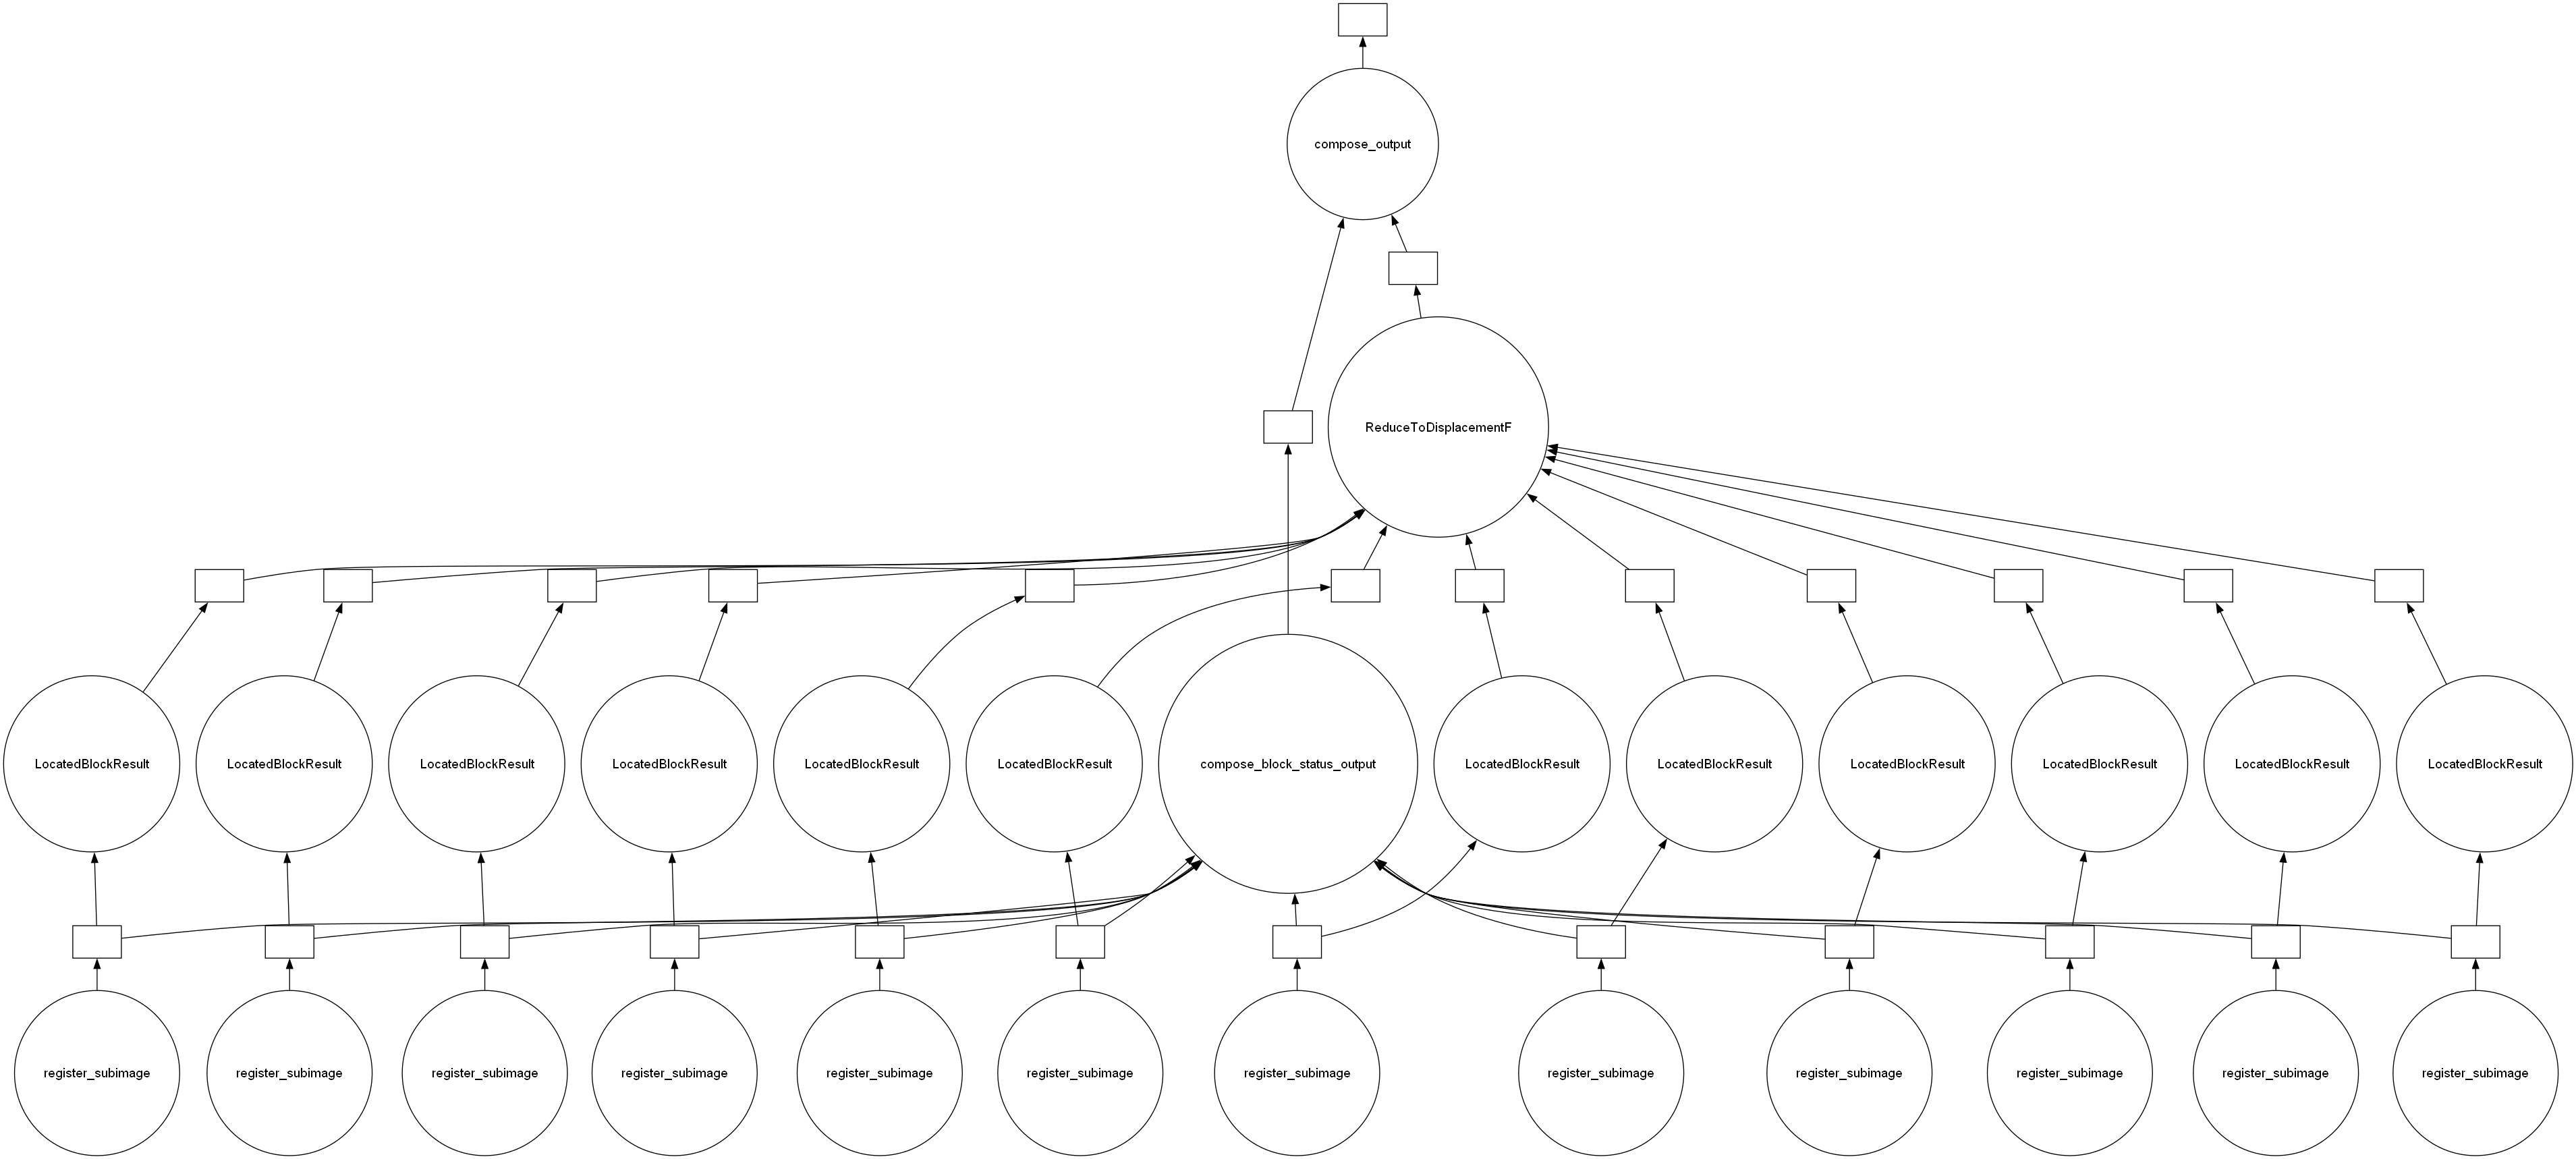

In [14]:
delayed_result.registration_result.visualize()

## Run Registration

Finalize configuration and run the actual registration process. May take a few minutes.

In [15]:
# Configure registration schedule execution.

# Configure dask to run locally either in serial or in parallel (default).
# dask.config.set(scheduler='synchronous')
dask.config.set(scheduler="threads")

# Configure logging output verbosity
logging.root.setLevel(logging.INFO)
itk.auto_progress(0)

In [16]:
# Run distributed image registration.
# Returns a `RegistrationResult` object indicating registration status and transform output.
result = delayed_result.registration_result.compute()

2023-11-10 11:02:03,005 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(1, 0, 1), array_slice=(slice(24, 42, None), slice(0, 24, None), slice(24, 48, None)))
2023-11-10 11:02:03,008 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(1, 1, 0), array_slice=(slice(24, 42, None), slice(24, 48, None), slice(0, 24, None)))
2023-11-10 11:02:03,017 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(0, 1, 0), array_slice=(slice(0, 24, None), slice(24, 48, None), slice(0, 24, None)))
2023-11-10 11:02:03,023 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(0, 2, 1), array_slice=(slice(0, 24, None), slice(48, 62, None), slice(24, 48, None)))
2023-11-10 11:02:03,025 - distributed.worker - INFO - Entering "register subimage" with block BlockInfo(chunk_index=(1, 2, 0), array_slice=(slice(24, 42, None), slice(48, 62, None), slice(0

In [17]:
# Reconfigure for remaining notebook procedures
logging.root.setLevel(logging.INFO)
itk.auto_progress(0)

## Inspect Results

We inspect the results of distributed pairwise registration:
- `result.status` indicates whether each pairwise registration routine succeeded or failed;
- `result.transforms` determines how to map from the initialized fixed image to the moving image

In [18]:
# Inspect the status of each registration task corresponding to a fixed image chunk
print(
    f"Registration tasks completed with respective status:\n"
    f"{result.status == itk_dreg.base.image_block_interface.BlockRegStatus.SUCCESS}"
)

Registration tasks completed with respective status:
[[[ True  True]
  [ True  True]
  [ True  True]]

 [[ True  True]
  [ True  True]
  [ True  True]]]


Output transform has type <class 'itk.itkDisplacementFieldTransformPython.itkDisplacementFieldTransformD3'>
Output displacement field has shape (NumPy convention): (9, 13, 10, 3)


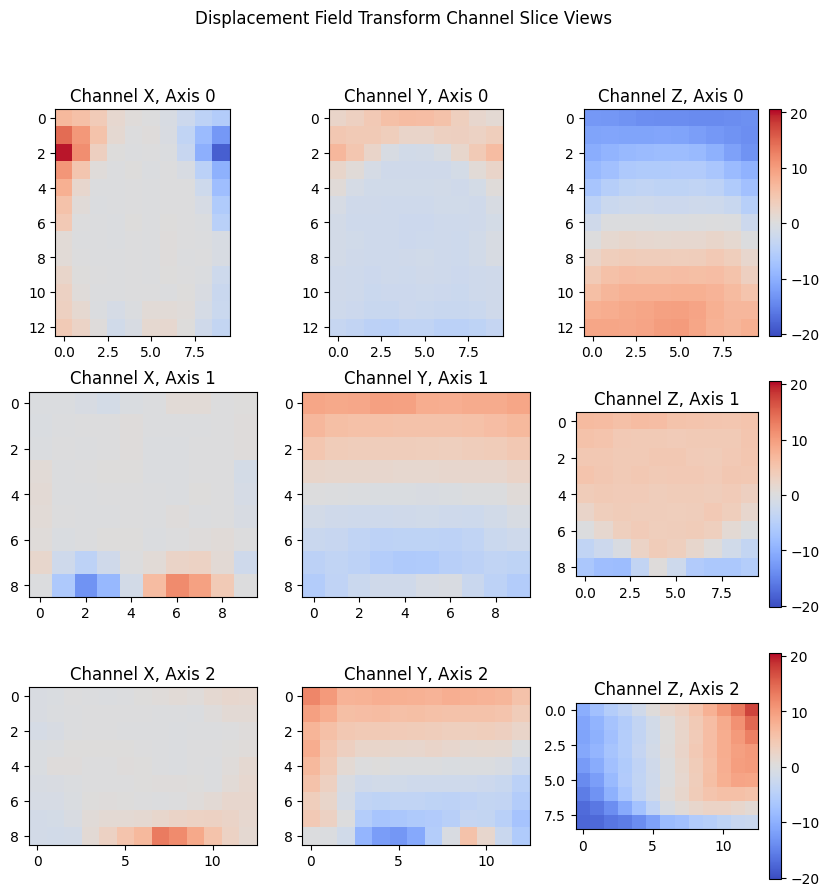

In [19]:
# Visualize the overall displacement field transform result from distributed registration.
# The displacement field transform output describes a displacement vector image
# where each voxel vector maps from a position in initialized fixed image space
# to a position in moving image space.
# For a 3D image channel 0 represents a movement along the "x" physical axis,
# channel 1 along "y", and channel 2 along "z".
# The displacement field acts as a discrete representation of multiple transform results
# that are blended to produce a single transform describing the entire input domain.

print(f"Output transform has type {type(result.transforms.transform)}")

field_image = result.transforms.transform.GetDisplacementField()
print(f"Output displacement field has shape (NumPy convention): {field_image.shape}")


import matplotlib as mpl

pltkwargs = {
    "cmap": plt.get_cmap("coolwarm"),
    "norm": mpl.colors.Normalize(vmin=np.min(field_image), vmax=np.max(field_image)),
}
SLICE_INDICES = [5, 8, 6]  # selected approximately halfway along each axis

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[10, 10])
for channel, channel_name in enumerate(("X", "Y", "Z")):
    for slice_dim in range(3):
        axs[slice_dim, channel].set_title(f"Channel {channel_name}, Axis {slice_dim}")
    axs[0, channel].imshow(field_image[SLICE_INDICES[0], :, :, channel], **pltkwargs)
    axs[1, channel].imshow(field_image[:, SLICE_INDICES[1], :, channel], **pltkwargs)
    axs[2, channel].imshow(field_image[:, :, SLICE_INDICES[2], channel], **pltkwargs)

for slice_dim in range(3):
    plt.colorbar(mappable=mpl.cm.ScalarMappable(**pltkwargs), ax=axs[slice_dim, 2])

fig.suptitle("Displacement Field Transform Channel Slice Views")
plt.show()

## Apply Results

We apply the transform results of distributed registration to sample the moving image into fixed image space.

In [20]:
# The transform result from distributed registration describes a mapping after the initial
# transform is applied. For a complete fixed-to-moving image transform the transform result
# must be composed with the initial transform.

output_transform = itk.CompositeTransform[itk.D, DIMENSION].New()
output_transform.PrependTransform(initial_transform)
output_transform.PrependTransform(result.transforms.transform)
# output_transform.PrependTransform(result.transforms.transform.transforms[0].GetNthTransform(2))
print(
    "Composed registration stage results to get a "
    f"fixed-to-moving transform with {output_transform.GetNumberOfTransforms()} stages"
)

Composed registration stage results to get a fixed-to-moving transform with 2 stages


In [21]:
# Read the fixed and moving image buffers into memory for visualization
moving_reader = moving_reader_ctor()
moving_reader.Update()
moving_image = moving_reader.GetOutput()
fixed_reader = fixed_reader_ctor()
fixed_reader.Update()
fixed_image = fixed_reader.GetOutput()

# Resample with only the initial transform for comparison
moving_image_init = itk.resample_image_filter(
    moving_image,
    transform=initial_transform,
    use_reference_image=True,
    reference_image=fixed_image,
)

# Resample with the composed initial+optimized transform result
resampled_image = itk.resample_image_filter(
    moving_image,
    transform=output_transform,
    use_reference_image=True,
    reference_image=fixed_image,
)

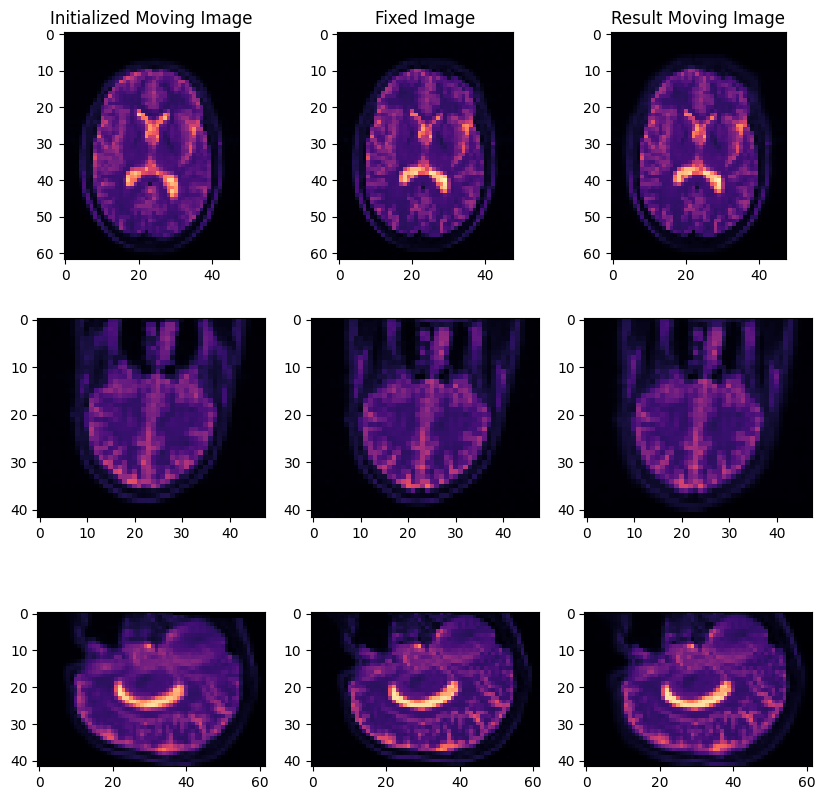

In [22]:
SLICE_INDICES = [20, 20, 20]
IMAGES = [moving_image_init, fixed_image, resampled_image]
IMAGE_NAMES = ["Initialized Moving Image", "Fixed Image", "Result Moving Image"]

pltkwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(vmin=np.min(fixed_image), vmax=np.max(fixed_image)),
}

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[10, 10])
for image_idx, image in enumerate(IMAGES):
    axs[0, image_idx].imshow(image[SLICE_INDICES[0], :, :], **pltkwargs)
    axs[1, image_idx].imshow(image[:, SLICE_INDICES[1], :], **pltkwargs)
    axs[2, image_idx].imshow(image[:, :, SLICE_INDICES[2]], **pltkwargs)

for image_idx, image_name in enumerate(IMAGE_NAMES):
    axs[0, image_idx].set_title(image_name)

## Evaluate Results

We visually evaluate to determine how well distributed registration improved on the initial fixed-to-image transform.

The initial difference image has a voxel delta of +/-150, whereas the registered image has a voxel delta of +/-3.

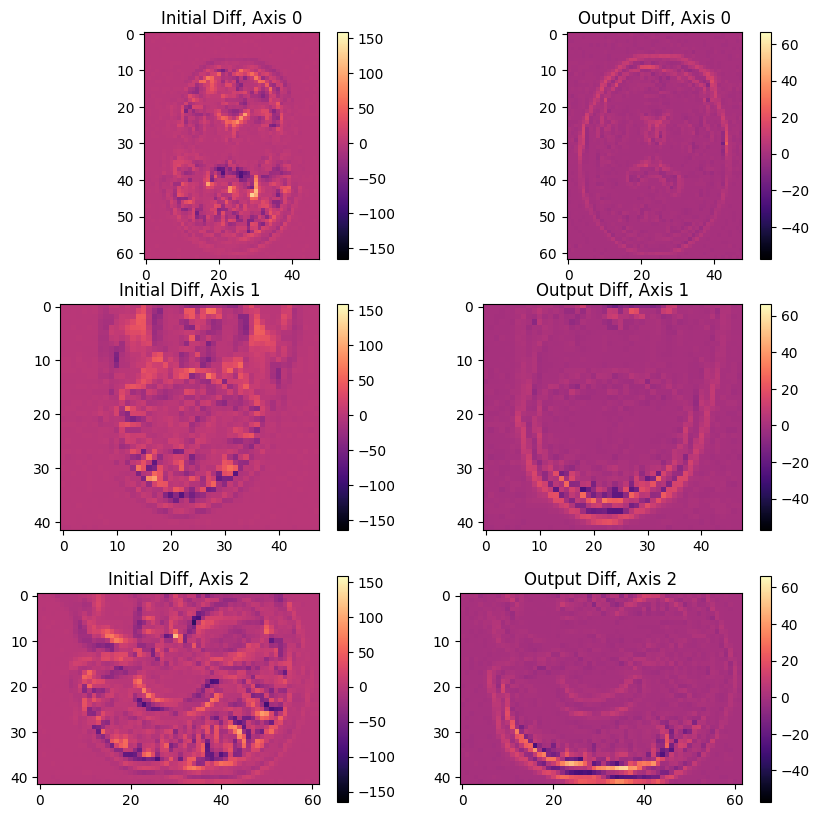

In [23]:
initialized_diff_image = itk.array_view_from_image(
    moving_image_init
) - itk.array_view_from_image(fixed_image)
result_diff_image = itk.array_view_from_image(
    resampled_image
) - itk.array_view_from_image(fixed_image)

init_kwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(
        vmin=np.min(initialized_diff_image), vmax=np.max(initialized_diff_image)
    ),
}

result_kwargs = {
    "cmap": plt.get_cmap("magma"),
    "norm": mpl.colors.Normalize(
        vmin=np.min(result_diff_image), vmax=np.max(result_diff_image)
    ),
}

SLICE_INDICES = [20, 20, 20]
IMAGES = (initialized_diff_image, result_diff_image)
IMAGE_NAMES = ("Initial Diff", "Output Diff")
IMAGE_PLT_KWARGS = (init_kwargs, result_kwargs)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=[10, 10])
for image_idx, (image, pltkwargs) in enumerate(zip(IMAGES, IMAGE_PLT_KWARGS)):
    axs[0, image_idx].imshow(image[SLICE_INDICES[0], :, :], **pltkwargs)
    axs[1, image_idx].imshow(image[:, SLICE_INDICES[1], :], **pltkwargs)
    axs[2, image_idx].imshow(image[:, :, SLICE_INDICES[2]], **pltkwargs)
    for ax_idx in range(3):
        plt.colorbar(
            mappable=mpl.cm.ScalarMappable(**pltkwargs), ax=axs[ax_idx, image_idx]
        )
        axs[ax_idx, image_idx].set_title(f"{IMAGE_NAMES[image_idx]}, Axis {ax_idx}")

## Final Comments

In this notebook we have used distributed registration to generate an optimized fixed-to-moving transform along with a resampled moving image. In practice these results are commonly used to resample coincident data from moving into fixed space, such as transforming label or point annotations from the moving image to overlay on the fixed image.

This example deals with a simple dataset and registration approach. Several more realistic applications of distributed registration include:
- Large image registration in which whole images cannot be loaded into memory;
- Multiresolution image registration, where small downsampled images are first registered and then successive higher resolutions are initialized and further optimized;
- Multistage resolution, where successively complex transforms are optimized to yield precise image-to-image transform results.

We encourage the reader to further explore `itk`, `itk_dreg`, and related literature for registration approaches.